In [1]:
import os
import numpy as np
from PIL import Image
import torch

In [2]:
def load_images_from_folder(folder_path, image_size=(224, 224)):
    images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(image_size)
                    images.append(np.array(img))
                except Exception as e:
                    print(f"Failed on {img_path}: {e}")
    return np.array(images)

def augment_rotations(X, y):
    X_aug = []
    y_aug = []
    for k in [1, 2, 3]:  # 90, 180, 270 degrees
        X_rot = torch.rot90(X, k=k, dims=[2, 3])  # rotate along H and W
        X_aug.append(X_rot)
        y_aug.append(y.clone())  # Same labels for rotated images
    return torch.cat(X_aug), torch.cat(y_aug)

In [3]:
onion_folder = "Onion_512"
strawberry_folder = "Strawberry_512"
pear_folder = "Pear_512"
tomato_folder = "Tomato_512"

In [4]:


onion_images = load_images_from_folder(onion_folder)
strawberry_images = load_images_from_folder(strawberry_folder)
pear_images = load_images_from_folder(pear_folder)
tomato_images = load_images_from_folder(tomato_folder)

print("onion_images:", onion_images.shape)
print("strawberry_images:", strawberry_images.shape)
print("pear_images:", pear_images.shape)
print("tomato_images:", tomato_images.shape)


onion_images: (2332, 224, 224, 3)
strawberry_images: (2455, 224, 224, 3)
pear_images: (3070, 224, 224, 3)
tomato_images: (3046, 224, 224, 3)


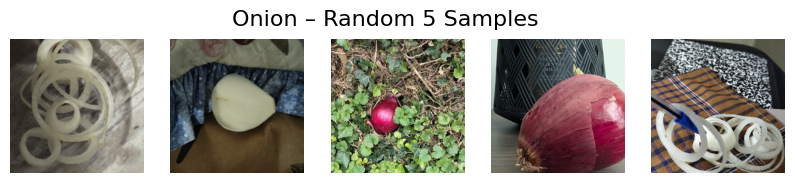

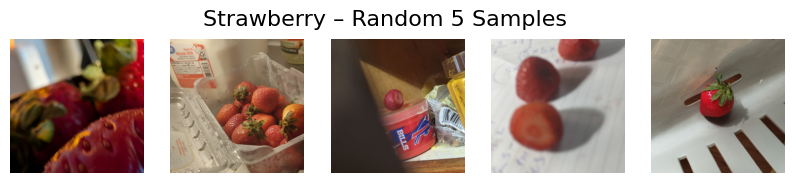

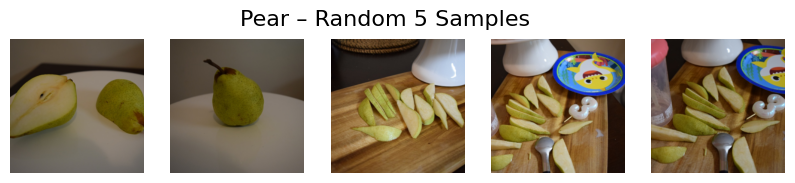

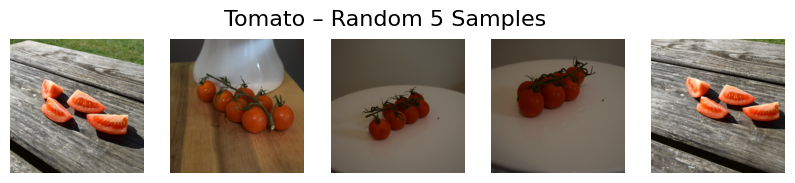

In [5]:
import matplotlib.pyplot as plt
import random
datasets = {
    "onion": onion_images,
    "strawberry": strawberry_images,
    "pear": pear_images,
    "tomato": tomato_images
}


def show_random_samples(images, class_name, count=5):
    indices = random.sample(range(images.shape[0]), count)
    selected = images[indices]

    plt.figure(figsize=(10, 2))
    for i, img in enumerate(selected):
        plt.subplot(1, count, i+1)
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')
    plt.suptitle(f"{class_name.capitalize()} – Random {count} Samples", fontsize=16)
    plt.show()

# Display for each class
for class_name, image_array in datasets.items():
    show_random_samples(image_array, class_name)


In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Combine data
X = np.concatenate([onion_images, strawberry_images, pear_images, tomato_images], axis=0)
y = (
    ['onion'] * len(onion_images) +
    ['strawberry'] * len(strawberry_images) +
    ['pear'] * len(pear_images) +
    ['tomato'] * len(tomato_images)
)

# Normalize and convert to torch tensors
X = X.astype(np.float32) / 255.0
X = np.transpose(X, (0, 3, 1, 2))  # (N, C, H, W)
X_tensor = torch.tensor(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_tensor = torch.tensor(y_encoded)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.5, stratify=y_tensor, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:
batch_size = 32

X_augmented, y_augmented = augment_rotations(X_train, y_train)

# Combine original and augmented data
X_train_combined = torch.cat([X_train, X_augmented])
y_train_combined = torch.cat([y_train, y_augmented])

# Create new training dataset and loader

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

# DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
print(f"🔢 Train Dataset: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"🔢 Val Dataset:   {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"🔢 Test Dataset:  {len(test_dataset)} samples, {len(test_loader)} batches")

🔢 Train Dataset: 21804 samples, 682 batches
🔢 Val Dataset:   2726 samples, 86 batches
🔢 Test Dataset:  2726 samples, 86 batches


In [9]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torchvision.models as models

def get_efficientnet_model(num_classes):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Replace classifier head with custom head
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model



In [10]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available. Using CPU")

model = get_efficientnet_model(num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


✅ Using MPS (Apple GPU)


In [ ]:
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accs = []
val_accs = []
epochs_no_improve = 0
early_stop = False
patience = 3

for epoch in range(10):
    if early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        preds = model(batch_x)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Track training accuracy
        pred_labels = preds.argmax(dim=1)
        train_correct += (pred_labels == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    
    model.eval()
    val_correct = val_total = 0

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_preds = model(val_x).argmax(dim=1)
            val_correct += (val_preds == val_y).sum().item()
            val_total += val_y.size(0)

    val_accuracy = val_correct / val_total
    validation_loss = criterion(model(val_x), val_y).item()

    # After calculating val_accuracy
    val_losses.append(validation_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_model_v1.pth")
        print(f"New best model saved at epoch {epoch+1} with val acc {val_accuracy:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print(f"Validation accuracy did not improve for {patience} consecutive epochs. Stopping early.")
        early_stop = True



Epoch 01 | Train Loss: 0.0675 | Train Acc: 0.9790 | Val Acc: 0.9967
New best model saved at epoch 1 with val acc 0.9967
Epoch 02 | Train Loss: 0.0203 | Train Acc: 0.9939 | Val Acc: 0.9963
No improvement for 1 epoch(s)
Epoch 03 | Train Loss: 0.0226 | Train Acc: 0.9937 | Val Acc: 0.9956
No improvement for 2 epoch(s)
Epoch 04 | Train Loss: 0.0165 | Train Acc: 0.9956 | Val Acc: 0.9974
New best model saved at epoch 4 with val acc 0.9974
Epoch 05 | Train Loss: 0.0250 | Train Acc: 0.9941 | Val Acc: 0.9971
No improvement for 1 epoch(s)


KeyboardInterrupt: 

: 

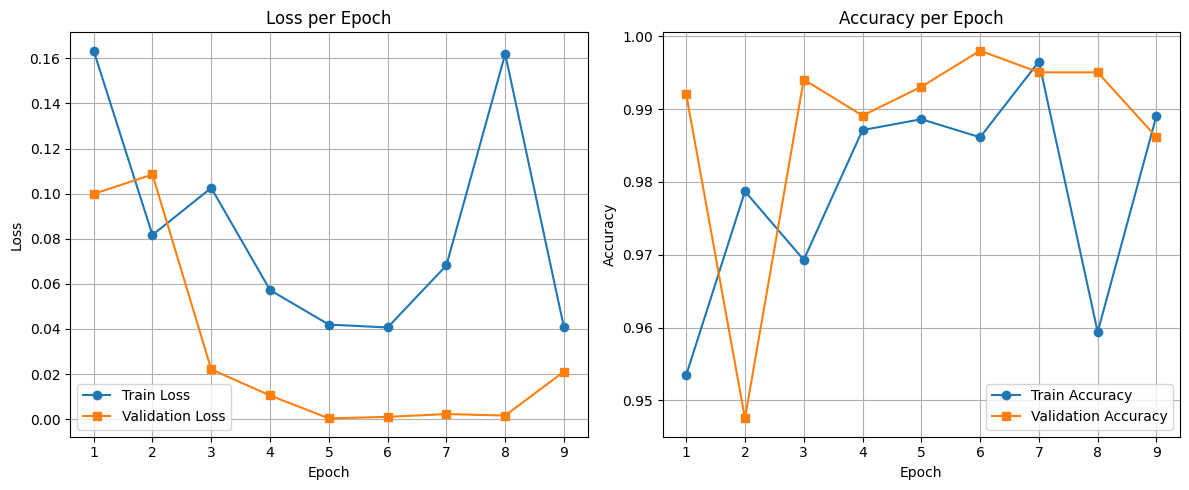

In [39]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accs, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



✅ Test Accuracy: 0.9881

📊 Classification Report:

              precision    recall  f1-score   support

       onion       0.96      1.00      0.98       250
        pear       1.00      1.00      1.00       255
  strawberry       1.00      0.96      0.98       250
      tomato       1.00      1.00      1.00       255

    accuracy                           0.99      1010
   macro avg       0.99      0.99      0.99      1010
weighted avg       0.99      0.99      0.99      1010



/var/folders/vj/mbznbr_s7fb1cqsqnx00ch_m0000gn/T/ipykernel_79754/1302256466.py:41: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/saksham_lakhera/Desktop/CNN training/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


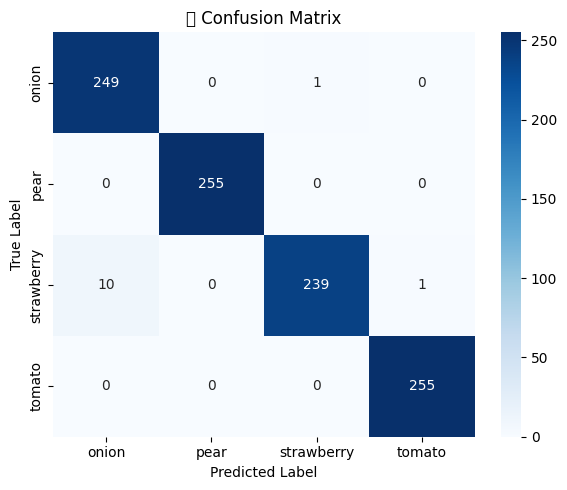

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Ensure model is in eval mode
model.eval()

# Collect all true and predicted labels
all_preds = []
all_targets = []
all_images = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        preds = model(batch_x).argmax(dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_targets.extend(batch_y.numpy())
        all_images.extend(batch_x.cpu())

# Compute accuracy
test_correct = sum(np.array(all_preds) == np.array(all_targets))
test_total = len(all_targets)
test_accuracy = test_correct / test_total

print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# Classification report
target_names = le.classes_  # ['onion', 'pear', 'strawberry', 'tomato']
print("\n📊 Classification Report:\n")
print(classification_report(all_targets, all_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🔍 Confusion Matrix")
plt.tight_layout()
plt.show()



🔍 Showing False Negatives and False Positives for class: onion


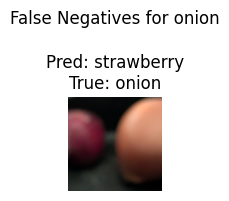

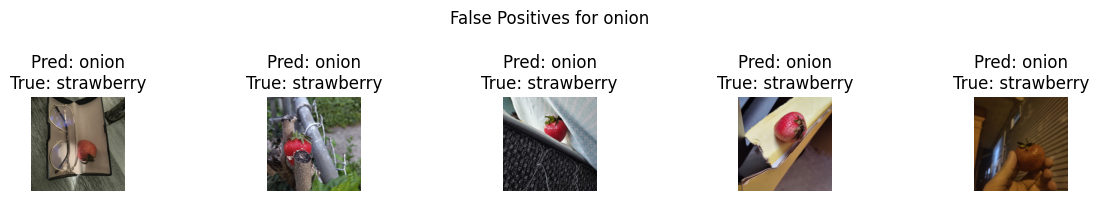


🔍 Showing False Negatives and False Positives for class: pear
❌ No False Negatives samples.
❌ No False Positives samples.

🔍 Showing False Negatives and False Positives for class: strawberry


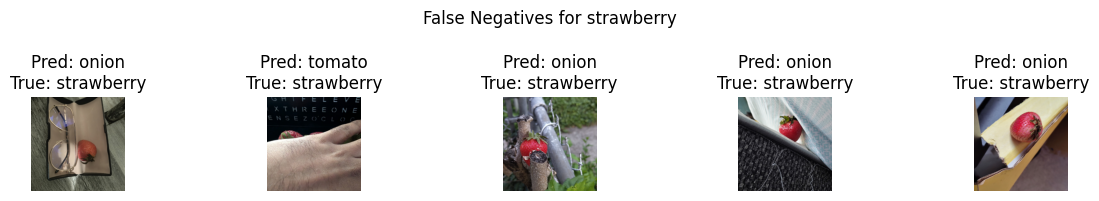

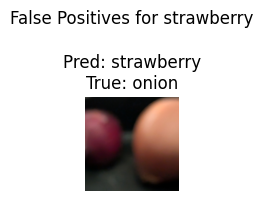


🔍 Showing False Negatives and False Positives for class: tomato
❌ No False Negatives samples.


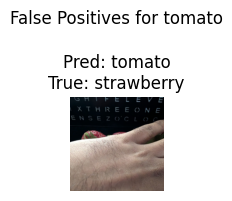

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_images = torch.stack(all_images)  # shape: [N, C, H, W]

# Per class FP and FN
for class_idx, class_name in enumerate(target_names):
    print(f"\n🔍 Showing False Negatives and False Positives for class: {class_name}")

    # False Negatives: True label is class_idx, but predicted something else
    fn_indices = np.where((all_targets == class_idx) & (all_preds != class_idx))[0]
    # False Positives: Predicted class_idx, but true label is different
    fp_indices = np.where((all_preds == class_idx) & (all_targets != class_idx))[0]

    def show_images(indices, title, max_images=5):
        num = min(len(indices), max_images)
        if num == 0:
            print(f"❌ No {title} samples.")
            return

        plt.figure(figsize=(12, 2))
        for i, idx in enumerate(indices[:num]):
            img = all_images[idx]
            img = img.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
            plt.subplot(1, num, i + 1)
            plt.imshow((img - img.min()) / (img.max() - img.min()))  # normalize to [0,1] for display
            plt.axis('off')
            plt.title(f"Pred: {target_names[all_preds[idx]]}\nTrue: {target_names[all_targets[idx]]}")
        plt.suptitle(f"{title} for {class_name}")
        plt.tight_layout()
        plt.show()

    show_images(fn_indices, "False Negatives")
    show_images(fp_indices, "False Positives")
